Propositions de modèles : NBC, LDA.
Il faudrait faire une pipeline de validation.
A chaque changement dans le preprocessing ou de modèle il faut retester pour comparer.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Chargement du dataset
with open("./data/train.txt", 'r') as f:
    data = f.read()[:-1] # On supprime la dernière ligne

# Découpage en liste de textes
data = data.split('\n')
# Récupération de l'étiquette
data = [(t[0:5][1:-1], t[5:]) for t in data]

# Conversion vers Pandas DataFrame
df = pd.DataFrame(data, columns=["language", "text"])
df.head()

,language,text
0,GER,IThe importance and popularity of travelling ...
1,TUR,"It is an important decision , how to plan you..."
2,CHI,Some people believe that young people can enj...
3,TEL,Travelling is usually considered as good recr...
4,ARA,i agree that . Life is a person live period o...


In [3]:
df["language"].unique()

array(['GER', 'TUR', 'CHI', 'TEL', 'ARA', 'SPA', 'HIN', 'JPN', 'KOR',
       'FRE', 'ITA'], dtype=object)

In [4]:
df["text"].nunique()

9900

In [5]:
df.groupby("language").count()

,text
language,
ARA,900
CHI,900
FRE,900
GER,900
HIN,900
ITA,900
JPN,900
KOR,900
SPA,900


# Langues
* FRA = Français
* GER = Allemand
* ITA = Italien
* ESP = Espagnol
* ARA = Arabe
* KOR = Coréen
* JPN = Japonais
* CHI = Chilien
* TEL = Télougou
* HIN = Hindi
* TUR = Turc

# Découpage
On pourrait faire de la cross-validation pour optimiser les hyperparamètres.
Mais dans un premier temps on peut simplement découper en trois parties notre dataset : Train, Valid et Test.
Comme il y a 900 observations par langue on va découper en 600, 200, 100.

In [6]:
size = [600, 200, 100]
assert sum(size) == 900
df["rank"] = df.sample(frac=1, random_state=42).groupby("language")["language"].rank(method="first", ascending=True)
df_train = df[df["rank"] <= size[0]].drop("rank", axis=1)
df_valid = df[(size[0] < df["rank"]) & (df["rank"] <= size[0] + size[1])].drop("rank", axis=1)
df_test = df[(size[0] + size[1] < df["rank"]) & (df["rank"] <= size[0] + size[1] + size[2])].drop("rank", axis=1)

In [7]:
df_train.count()

language    6600
text        6600
dtype: int64

In [8]:
df_valid.count()

language    2200
text        2200
dtype: int64

In [9]:
df_test.count()

language    1100
text        1100
dtype: int64

In [10]:
X = df["text"]
X_train = df_train["text"]
y_train = df_train["language"]
X_valid = df_valid["text"]
y_valid = df_valid["language"]
X_test = df_test["text"]
y_test = df_test["language"]

Nous allons créer un premier pipeline avec une méthode d'évaluation.

# Bag of Words
Bag of Words est la méthode de vectorisation la plus simple qui consiste à compter le nombre d'occurences de chaque mot du vocabulaire.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
cv = CountVectorizer()
# On veut le même vocabulaire sur train et test
cv.fit(X)
cv_train = cv.transform(X_train)
cv_valid = cv.transform(X_valid)
cv_test = cv.transform(X_test)
cv_train.shape[0]

6600

# Linear SVC

In [13]:
from sklearn.svm import LinearSVC

In [14]:
model = LinearSVC(random_state=42, max_iter=1500)
model.fit(cv_train, y_train)
y_pred = model.predict(cv_valid)

In [15]:
def train(X_train, y_train, X_valid) -> np.array:
    model = LinearSVC(random_state=42, max_iter=1500)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return y_pred

# Score

In [16]:
from sklearn.metrics import accuracy_score, f1_score

In [17]:
accuracy_score(y_valid, y_pred)

0.6659090909090909

In [18]:
f1_score(y_valid, y_pred, average="macro")

0.6654162399577045

Ici on utilise la f1 score sans pondération. Dans notre cas le type d'erreur n'est pas un critère.

# Matrice de confusion

In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

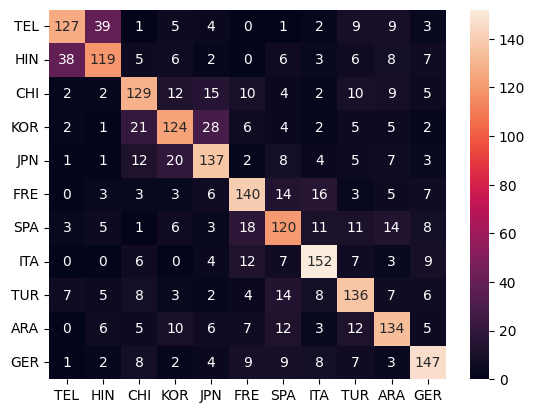

In [20]:
labels = ['TEL', 'HIN', 'CHI', 'KOR', 'JPN', 'FRE', 'SPA', 'ITA', 'TUR', 'ARA', 'GER']
matrix = metrics.confusion_matrix(y_valid, y_pred, labels=labels)
sns.heatmap(matrix, annot=True, fmt='.3g', xticklabels=labels, yticklabels=labels)
plt.yticks(rotation=0)
plt.show()

In [21]:
def evaluate(y_valid, y_pred):
    print(f"accuracy: {accuracy_score(y_valid, y_pred)}")
    print(f"f1-score: {f1_score(y_valid, y_pred, average='macro')}")
    labels = ['TEL', 'HIN', 'CHI', 'KOR', 'JPN', 'FRE', 'SPA', 'ITA', 'TUR', 'ARA', 'GER']
    matrix = metrics.confusion_matrix(y_valid, y_pred, labels=labels)
    sns.heatmap(matrix, annot=True, fmt='.3g', xticklabels=labels, yticklabels=labels)
    plt.yticks(rotation=0)
    plt.show()

# Caractères

In [22]:
from collections import Counter

In [23]:
counter = Counter([c for doc in X for c in doc])
counter

Counter({' ': 3452797,
         'I': 62484,
         'T': 36018,
         'h': 695791,
         'e': 1814180,
         'i': 937505,
         'm': 343676,
         'p': 327313,
         'o': 1128626,
         'r': 771923,
         't': 1334123,
         'a': 1041637,
         'n': 984804,
         'c': 431518,
         'd': 472773,
         'u': 416545,
         'l': 570986,
         'y': 324570,
         'f': 283569,
         'v': 166801,
         'g': 268564,
         's': 866695,
         ',': 127352,
         'E': 6669,
         'b': 196444,
         'k': 106117,
         'w': 258693,
         '.': 158991,
         'A': 18244,
         'W': 8631,
         'S': 14003,
         'F': 13330,
         'x': 28415,
         'z': 9470,
         'j': 33452,
         '-': 4735,
         'U': 2180,
         'M': 6256,
         'B': 9426,
         'O': 7328,
         'q': 8209,
         'N': 5123,
         "'": 25603,
         'D': 2466,
         'L': 3176,
         'Y': 3990,
         '/': 112

On n'a pas de caractères bizarres tout est ASCII. Par contre l'utilisation de certains caractères peut être abusive notamment en ce qui concerne les caractères spéciaux.

In [24]:
# Recherche de documents comportant des caractères spéciaux
def find_example(char: str, window: int = 16, index=False):
    res = []
    for idx, doc in enumerate(X):
        occ = [i for i, c in enumerate(doc) if c == char]
        for i in occ:
            ext = doc[max(0, i-window):i+window+1]
            if index:
                ext = (idx, ext)
            res.append(ext)
    return res

In [25]:
find_example("'", index=True)[3]

(6, " the statement '' Young people no")

In [26]:
find_example('+')[0]

"ave learned ` 1 + 1 = 2 ' . we kn"

In [27]:
find_example('*')[3]

'. Conclusion : ************** I d'

In [28]:
find_example('=')[0]

"learned ` 1 + 1 = 2 ' . we know n"

In [29]:
find_example('#')[0]

' are as below : # Ideas and conce'

In [30]:
find_example('~')[0:3]

['pproximately 20 ~ 30 % of their b',
 ', If you are 50 ~ 60 years old yo',
 '< < < < < __ -- ~ ~ -- __The End ']

In [31]:
find_example('|')[0]

' later life you | ll not be able '

In [32]:
find_example('[')[0]

'be the best age [ use of young pe'

In [33]:
find_example('{')[0]

' do not pollute { like sun , wind'

In [34]:
find_example('_', index=True)[0:3]

[(1762, 'icles and roller_skates to go to '),
 (2397, ' not during week_end and also the'),
 (3065, '< < < < < < < < __ -- ~ ~ -- __Th')]

In [35]:
X[3065][-75:]

' < < < < < < < < < __ -- ~ ~ -- __The End __ -- ~ ~ -- __ > > > > > > > > >'

In [36]:
X[4770][:100]

" `` TRY AND TRY UNTILL U SUCCED '' ____________________________________________________ - i agree wi"

In [37]:
find_example('\\')[0]

"have adapt to t \\ people 's expec"

In [38]:
find_example('`')[3]

' a saying that `` teach him ` how'

In [39]:
find_example('´')

['g something won ´ t be useless bu']

In [40]:
find_example('^')[0]

'dfather sayed : ^ Give a smile an'

In [41]:
find_example('%')[0]

'ical records.70 % of the people r'

In [42]:
import re

def correct_special_chars(doc: str) -> str:
    # Harmonisation de la ponctuation
    doc = re.sub(r"[\[{]", "(", doc)
    doc = re.sub(r"[\]}]", ")", doc)
    
    # Suppression des caractères spéciaux
    doc = re.sub(r"[+*=#~^|_\\'`´]", "", doc)
    
    return doc

accuracy: 0.6672727272727272
f1-score: 0.6665963286741187


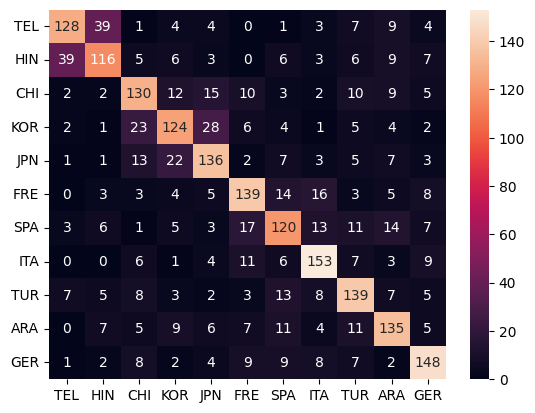

In [43]:
X_g = X.apply(correct_special_chars)
X_t = X_train.apply(correct_special_chars)
X_v = X_valid.apply(correct_special_chars)
cv = CountVectorizer()
cv.fit(X_g)
cv_t = cv.transform(X_t)
cv_v = cv.transform(X_v)
y_pred = train(cv_t, y_train, cv_v)
evaluate(y_valid, y_pred)

La correction des caractères spéciaux ne change pratiquement pas le score.

# Tokenization des nombres

In [44]:
count = 0
for doc in X_t:
    if re.match(".*\d.*", doc) is not None:
        count += 1

Il y a `1249/6600 = 18%` de documents dans le train avec des nombres. Est-ce qu'on ne pourrait pas tokenizer les nombres ?

In [45]:
def tokenize_numbers(doc: str) -> str:
    return re.sub("\d+", "#NUMBER", doc)

accuracy: 0.6663636363636364
f1-score: 0.6656707454648134


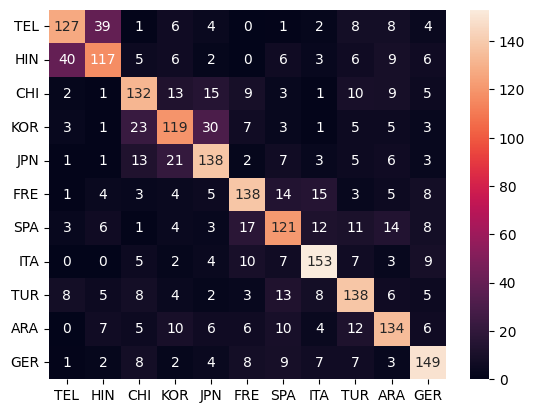

In [46]:
def preprocessing(doc: str) -> str:
    doc = correct_special_chars(doc)
    doc = tokenize_numbers(doc)
    return doc

X_g = X.apply(preprocessing)
X_t = X_train.apply(preprocessing)
X_v = X_valid.apply(preprocessing)
cv = CountVectorizer()
cv.fit(X_g)
cv_t = cv.transform(X_t)
cv_v = cv.transform(X_v)
y_pred = train(cv_t, y_train, cv_v)
evaluate(y_valid, y_pred)

Cette tokenization n'a pratiquement aucun effet sur le score.

# Optimisation CountVectorizer